# 1. About The Data: German Credit Risk

The data come from Kaggle about German Credit Risk in which there is a need to predict whatever or not the loan are good or bad. The data originaly come from Prof.Hofmann that also able to be found at UCI Machine Learning Repository. In Kaggle it could be seen that the data has 1000 rows and 9 predictor that is:
- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (text, like in saving accounts)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others).
Additionally there is another 1 feature that is Risk which become the target feature in the data

# 2.Main Objectives
I wich to create model that has the capability to classify which are good or bad loans. Additionally i wish the model can be as simple as possible to enable interpretation and better analysis. Since the data is about classifying the good or bad loans and the fact that the bank wants to protect their image and also maximixing return. Therefore for the sake of bank reputation and need to risk managenent, the appropriate metrics will be the balance of recall and precision. On one hand, if the many bad loans are not identified (false negative), then the Banks or credit provider will potentially has loss ir even liquidity problem. But on the other hand if there is many good loans being identified as bad loans (false positive) then there could be reduced availability for loan for the client in the future. If the  client perhaps is not that well off or retail customer then perhaps recall will be suitable more. In any case i hope that all the model able to achive precision, recall, and f 1 score of 80% as my goals. 

# 3.What would i do?
First thing i would to is to explore the data which comprised of:
- Divide the feature into ordinal, nominal, and numeric features
- Create scatterplot for the numeric feature and serach for the characteristics
- For the categorical fesature shall use bocplot
- Check if there is any null and do something for the null
- Identify outliers and handle it
The classification problem in this case will have logistic regression as the baseline which then will be compared to K Nearest Neighbout, Support Vector Machinr, decision tree, and ensemble (optional). Then search for the feature interpretability is also aside predicting the loan't quality. Also check for the performance metrics, if it done then job done, if not back to the beginning again.

In [1]:
# importing necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# metrics for evaluation
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

# 3.Understanding the Data

In [2]:
# read the data
data=pd.read_csv('D:/Dataset ML/Credit Risk/german_credit_data.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [4]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


From the summary of the data seen above and the 5 upper rows in the data, i could see that the data is about few data aout the debtors. The data is dominated by categorical feature and has missing value in two feature that is the availability of savings and checking account. The missing value is very prevalent so much so that if the missing value is eliminated, the data loss around 20% or 40% which means that there should be another way to handle the missing value. 

In [5]:
# eliminate the first column since it will not be a predictor
data=data.drop('Unnamed: 0',axis=1)

In [6]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

In [7]:
data['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [8]:
data['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

Based on the feature description all categorical variables, most of them are nominal variables with the exception of savings account and checking account. The missing value fot savings account and checking account later will be imputated by 'no account'. Additionally they are (based on my understanding) also ordinal feature since they represented possible the value in the each account.  

In [9]:
# understanding the proportion of the target feature
data['Risk'].value_counts(normalize=True)

good    0.7
bad     0.3
Name: Risk, dtype: float64

This mean that the data is unbalanced however moderate it is. This is something will be later addressed after the EDA finish so that the insight generated in EDA become another consideration for the strategy in the addressing imbalance

In conclusion most of the data here are categorical and only 3 are numerical, here is it:
- Age: numerical discrete
- Sex: categorical nominal
- Job: categorical ordinal
- Savings accounts: categorical ordinal
- Checking account: categorical ordinal
- Credit ammount: numerical continuous
- Duration: numerical discrete
- Purpose: categorical nominal

# 4.Data Cleaning
On this section, i shall do:
- Impute the missing value on 2 features
- Identify outliers on the numerical variables and perhaps deal with it

## 4.a.Impute the Missing value
Since there is variables that has up to 40% of the value, i shall see if there is rows or observation that has no saving and checking account because if they do it should be unrealistic unless this is about credit card. From what i know, for you to get a loan, you need to have either of those account or deposits. So assuming the banks need either of those account, i will impute the value of missing value for 2 cases:
- If there is either saving or checking account (one of them is not missing) then the missing value will be imputed with no account
- If there is missing value in both saving and checking then it shall be categorized as unidentified (optional) if there is at least 50 rows of data that has those condition, if not then just drop the rows.

In [10]:
# check if there is any rows that has missing value in saving and checking account
filtered=data[data['Saving accounts'].isnull() & data['Checking account'].isnull()]
filtered

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
5,35,male,1,free,NaN,NaN,9055,36,education,good
16,53,male,2,own,NaN,NaN,2424,24,radio/TV,good
24,26,male,2,own,NaN,NaN,2069,10,furniture/equipment,good
33,57,male,1,rent,NaN,NaN,1264,12,business,good
53,31,male,2,own,NaN,NaN,3378,18,car,good
...,...,...,...,...,...,...,...,...,...,...
947,38,male,3,own,NaN,NaN,2859,12,car,good
962,29,male,2,own,NaN,NaN,3556,15,car,good
968,29,male,2,rent,NaN,NaN,7166,42,radio/TV,good
990,37,male,1,own,NaN,NaN,3565,12,education,good


In [11]:
# impute the value of this condition using unidentified
for i in filtered.index:
    data.loc[i,'Saving accounts']='unidentified'
    data.loc[i,'Checking account']='unidentified'

In [12]:
# since the special case has been handled, the rest shall use the no account
data=data.fillna({'Saving accounts':'no acco', 'Checking account':'no acco'})

In [13]:
data['Saving accounts'].value_counts()

little          603
moderate        103
unidentified     99
no acco          84
quite rich       63
rich             48
Name: Saving accounts, dtype: int64

In [14]:
data['Checking account'].value_counts()

no acco         295
little          274
moderate        269
unidentified     99
rich             63
Name: Checking account, dtype: int64

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


## 4.b.Identify and Handle Outleirs

In [16]:
# filtered the numerical feature
numeric=['Age','Credit amount','Duration']

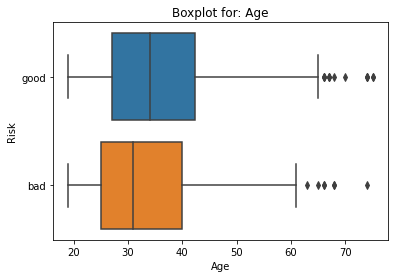

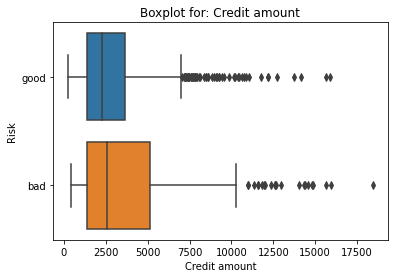

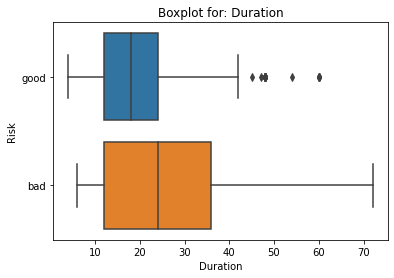

In [17]:
for i in range(len(numeric)):
    sns.boxplot(data=data, x=numeric[i],y='Risk')
    plt.title(f'Boxplot for: {numeric[i]}')
    plt.show()

For the outlier, i will turn blind eye for variable Duration and Age since there are only few of them anyway. However i must admit that for outlier to be handled into. But it needed to be understanded that there is indeed a case for large credit being given to individual because of variety of purposes and some of them could turn bad or good. However the distribution in credit ammount show how concentration on how much people actually get credit. On this case, most of them come from around 2000-5000 DM (deustche mark). It also shows how the larger credit ammount is, the greater possibility that the loan becoming bad.   

In [18]:
categorical=[col for col in data.columns if col not in numeric]

In [19]:
data['Saving accounts'].value_counts()

little          603
moderate        103
unidentified     99
no acco          84
quite rich       63
rich             48
Name: Saving accounts, dtype: int64

In [20]:
for col in categorical:
    print(f'Pivot Table between {col} Vs Risk')
    print("  ")
    pivot_table=pd.crosstab(index=data[col],columns=data['Risk'])
    print(pivot_table)
    print('----------------------------------------------------')

Pivot Table between Sex Vs Risk
  
Risk    bad  good
Sex              
female  109   201
male    191   499
----------------------------------------------------
Pivot Table between Job Vs Risk
  
Risk  bad  good
Job            
0       7    15
1      56   144
2     186   444
3      51    97
----------------------------------------------------
Pivot Table between Housing Vs Risk
  
Risk     bad  good
Housing           
free      44    64
own      186   527
rent      70   109
----------------------------------------------------
Pivot Table between Saving accounts Vs Risk
  
Risk             bad  good
Saving accounts           
little           217   386
moderate          34    69
no acco           23    61
quite rich        11    52
rich               6    42
unidentified       9    90
----------------------------------------------------
Pivot Table between Checking account Vs Risk
  
Risk              bad  good
Checking account           
little            135   139
moderate          105

Unbalanced also can be seen in the categorical feature which there is indeed at first glance disparity in the distribution. However there is indication that some category are prone to bad loan than the other. Which will be discused at the EDA since the purpose of showing the pivot table has always to see if there is unbalance of category and giving a glimse into the categorical variables.

In [21]:
# changing the dtype of credit ammount since i supposed they are likely to be continue 
data['Credit amount']=data['Credit amount'].astype('float64')

# 5.Exploratory Data Analysis (EDA)
In this section this is what i want to do to gain insight from the data it self. Here is my plan for the EDA divide by each numerical and categorical data or column:
- Numerical
    - Do boxplot to see if there is any need to include the variables 
    - Do scatterplot to determine the characteristics of the group
    - Generate heatmap for correlation each of them to see interaction
- Categorical:
    - Make histogram that also show the proportion of the quality of the loan or risk
    - Do chi squared test for independece to see the correlation between it's subordinate

## 5.a.Numeric Variables
The numeric feature is usually much more easier to 'handle' in regards of seeing relation with the target feature and their relation of with each other especially using heatmap. What i hope to gain in this EDA is:
1. Is there any 'numeric' difference between good or bad loan ?
2. See each numeric variables value distribution and identify if their value perhaps concentrated on one tail or not?
3. See the distribution of numeric variables and their relation with bad loan
4. Finally see their correlation with each other to see if there is some feature that actually necesaarily needed.
The aim no 1,2,3 will be achived through boxplot, histogram, or scatterplot while no 4 will be achived through scatterplot and correlation plot. 

In [22]:
# filtered the numerical feature
numeric=['Age','Credit amount','Duration']

#filtered the categorical
categoric=[col for col in data.columns if col!='Risk' and col not in numeric]

### 5.a.i.Univariate Analysis

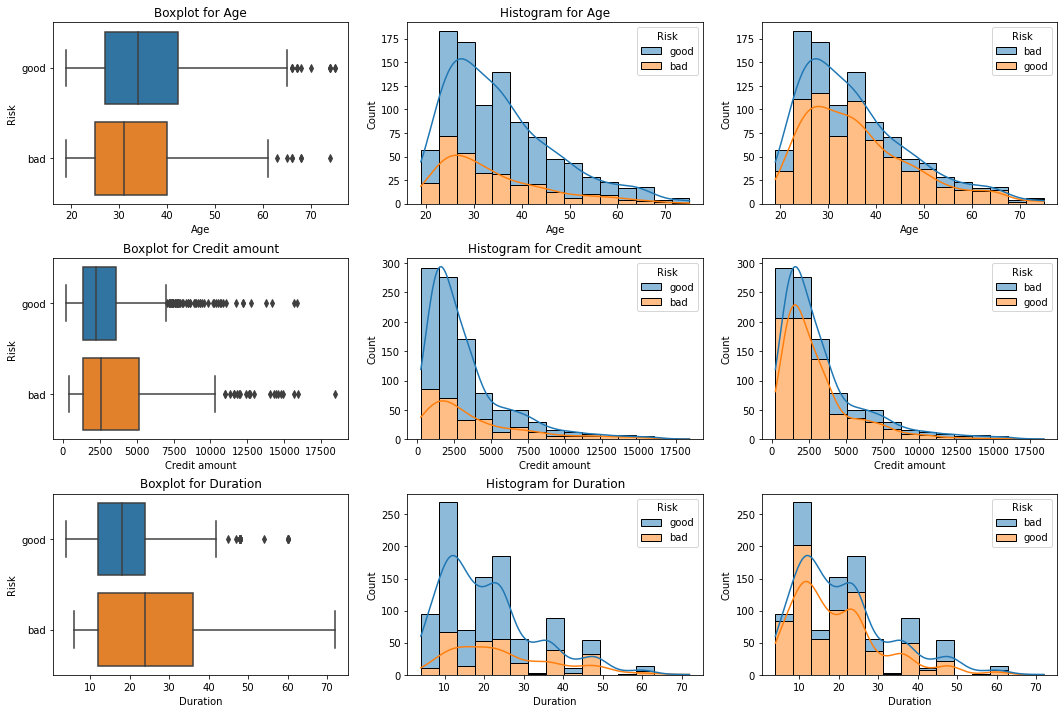

In [23]:
i=0
fig, axes = plt.subplots(3,3, figsize=(18, 12))
for col in numeric:
    sns.boxplot(data=data, x=col,y='Risk',ax=axes[i,0])
    axes[i,0].set_title(f'Boxplot for {col}')
    
    #creating the histogram
    sns.histplot(data=data,x=col,hue='Risk',bins=15,kde=True,stat='count',multiple='stack',hue_order=['good','bad'],ax=axes[i,1])
    axes[i,1].set_title(f'Histogram for {col}')
    
    #creating the histogram with focus on the good one
    sns.histplot(data=data,x=col,hue='Risk',bins=15,kde=True,stat='count',multiple='stack',hue_order=['bad','good'],ax=axes[i,2])
    axes[i,1].set_title(f'Histogram for {col}')
    i+=1

plt.subplots_adjust(hspace=0.3)
plt.show()

From the boxplot it could be seen that the variables Duration, Creadit amount, and Age, almost all value of the descriptive statictics (minimum, Q1,median,Q3,Maximum) is different between the good and bad loan. However the most visually different are Duration and Age while the Credit amount only started different at the Q3 values. Here is the summary what i found in the boxplot:
- Age: Generally speaking, those age for those that has bad loan are smaller than tho with good loan. Additionally there seems to be less people beyond 30 in the bad one while on the good one it only started around 33 years old. This perhaps may due to of the older people already has financial stability than the younger ones.
- Credit Amount: It seems bad loan has credit that slightly bigger than the good one. Around 75% of the credit in good one is less than 3000-3500 DM while in the bad one, 75% are below 5000 DM. The notable difference between the two category is started for the top 50% where the bad ones are more spread out in value whilte the good one are concentrated around lower value (which could become the reason of large outiers on the good one).
- Duration: It could be said that the loan duration of the good one are much more concentrated around 10-24 months while the bad one are much spread out in 10-35 months. Which perhaps tells us that higher loan duration is prone to risk which in practice is true.

While the boxplot show the general insight about the variable with the target feature, histogram show it in detail per range of values. Here is the summary of my finding:
- Age: The bad loan are concentrated around the age of 20-40 however the number of bad loan decreases at the same time age increases while reaching the peak for aound debtors in 20 years old. This perhaps due to the concervative financial management and the availability of the things that they need. Meanwhile younger are ready to take more risk and they perhaps didn't has the thins that they need yet so they overestimate them self.
- Credit amount: There is not really things to be seen since indeed there is smller bad loan as the credit amount increases but so is the count for credit in that value. But there is indeed quite a drop in the bad loan after loan value is 2500 DM. In the end there is concentration of loan around 5000 DM.
- Duration: There is not really any some of pattern happen in duration especially for bad loan. But there is indeed quite large increase in bad loan count for 10, 20, 25,35,45 months duration. However this seems not really important if there is no other value at other time since the plot for duration's bad lon over time is better.

Overall though, there seems to be large difference in category for this numeric category. In the end for the histogram i think better pattern using histogram that show percentage or proportion. However i will not do it since the creation of bar width and various other are not convenient.

### 5.a.ii.Bivariate Analysis

In [24]:
numerical=data[['Age','Credit amount','Duration','Risk']]

In [25]:
numerical.head()

,Age,Credit amount,Duration,Risk
0,67,1169.0,6,good
1,22,5951.0,48,bad
2,49,2096.0,12,good
3,45,7882.0,42,good
4,53,4870.0,24,bad


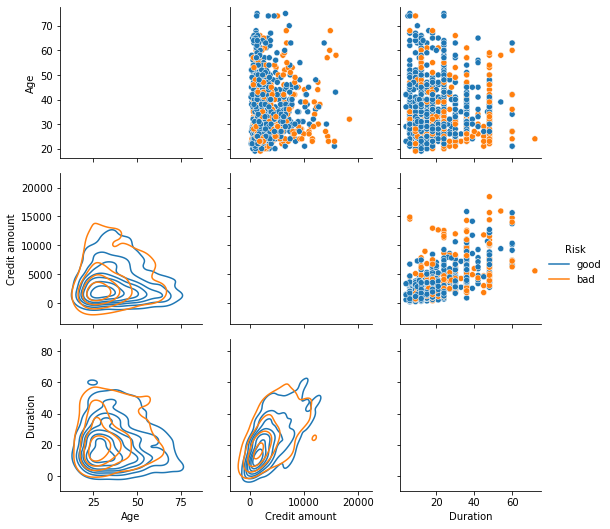

In [26]:
g=sns.PairGrid(numerical,hue='Risk')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot,levels=8)
g.add_legend()

From the above plot, here is the summary of my findings:
- There is quite a positive corrlation between Credit amount and Duration
- It seems that there is minimal correlation between age and the other 2 variables in which duration and credit ammount
- Both young and old can borrow monet for long duration and also for large ammount and so is the other way sround
- Unfortunately it self there is quite the similarity for both good and bad loan which mean actually for numerical feature there not really a difference in them. Perhaps if the model produced later bad, this 3 feature will be the first to be eliminated by myself.

### 5.a.iii.Correlation

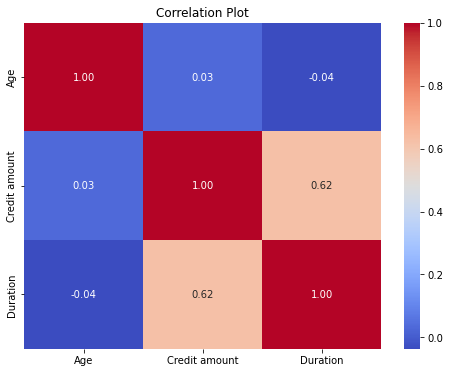

In [27]:
# i will make correlation between numerical variables
# make the correlation matrix first
correlation_matrix = numerical.corr()

# make the plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Plot")
plt.show()

There seems to be high correlation between credit amount and duration just like discussed earlier. This is indeed quite common in lending in which usually high credit are due for longer period than the smaller one. In the context of retail or individual loan however credit history decided both duration and credit amount given which means that usually the higher the credit or duration mean that the individual in question is trustworthy. This do make sense however in risk perspective, eliminating both of them could be unjust since both can be considered as important factors

In [28]:
# now time to get correlation between target feature and numeric variable
# i will use point biserial method 

# Map 'good' to 1 and 'bad' to 0 in the 'BinaryFeature' column
# the reason mapping like this is because i want to see the effect of feature to bad loan specifically
numerical.loc[:,'binary'] = numerical['Risk'].map({'bad': 1, 'good': 0})

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [29]:
# search for the correlation coefficient
correlation_coefficients = {}
for column in numerical.columns[:-2]:  # Exclude the last column which is the binary feature
    coefficient, _ = stats.pointbiserialr(numerical[column], numerical['binary'])
    correlation_coefficients[column] = coefficient

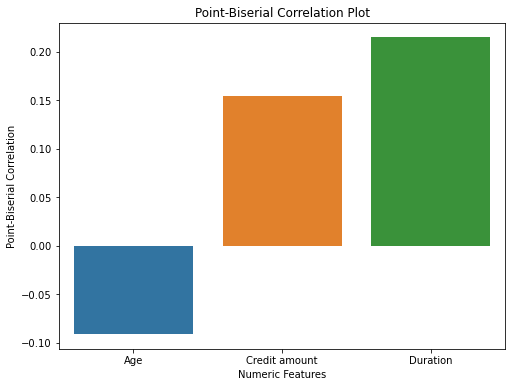

In [30]:
# Convert the coefficients to a DataFrame for plotting
correlation_df = pd.DataFrame.from_dict(correlation_coefficients, orient='index', columns=['Point-Biserial Correlation'])
correlation_df.index.name = 'Numeric Feature'
correlation_df.reset_index(inplace=True)

#create the plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Numeric Feature', y='Point-Biserial Correlation', data=correlation_df)
plt.title("Point-Biserial Correlation Plot")
plt.xlabel("Numeric Features")
plt.ylabel("Point-Biserial Correlation")
plt.show()

The relation between numerical and Risk seem to dismall using point biserial correlation. This is due to the nature of point biserial that uses the diffrence between mean of 2 different group (good vs bad loan). This is indeed no surptise since there is almost the same concentration of value between the 2 groups in all the numeric variables. It seems perhaps there is the need for other statistical measures. The other measures that i think of is ANOVA in which is hypotetical testing statistics. The null hypotesis is the is no significant differences among group means while the alternative is that there is at least one group that has different means than the other 

In [31]:
for feature in numerical.columns[:-2]:
    good_group = numerical[numerical['Risk'] == 'good'][feature]
    bad_group = numerical[numerical['Risk'] == 'bad'][feature]
    
    f_statistic, p_value = stats.f_oneway(good_group, bad_group)
    
    print(f"ANOVA for {feature}:")
    print(f"F-statistic: {f_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print()

ANOVA for Age:
F-statistic: 8.3570
P-value: 0.0039

ANOVA for Credit amount:
F-statistic: 24.4824
P-value: 0.0000

ANOVA for Duration:
F-statistic: 48.3338
P-value: 0.0000



It do suggest that there is some differences between mean in al 3 variables. This do suggest there is some differnces happening so i will keep them out to see if the categorical features has the same problem, if yes then i still need to keep them.

## 5.b.Categorical Feature

In [32]:
# Preparation
numeric=['Age','Duration','Credit amount']
categorical=[col for col in data.columns if col not in numeric]

In [33]:
category=data[categorical]

In [34]:
len(categorical)

7

### 5.b.i.Histogram

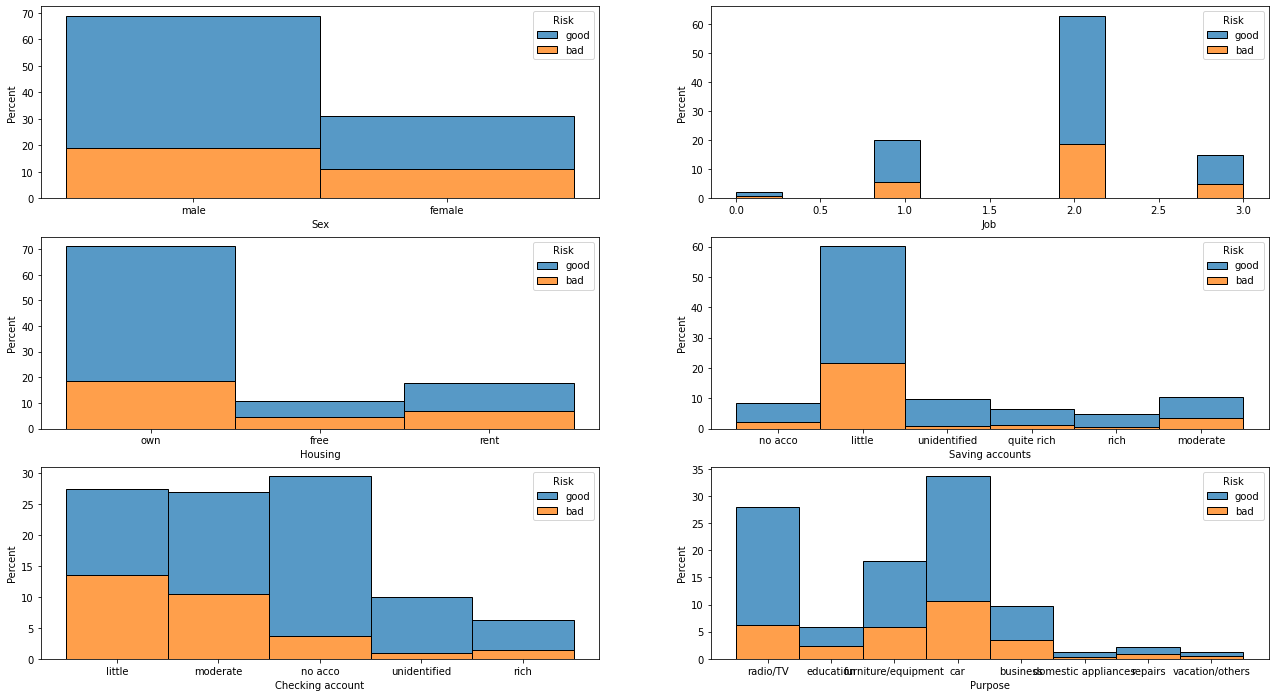

In [35]:
# to conserve space and since the category only has 6 anyway excluding the 'Risk' feature then use subplots
i=0
fig, axes = plt.subplots(3,2, figsize=(22, 12))
for col in category.columns[:-1]:
    if i%2==0:
        b=int(i/2)
        sns.histplot(data=category,x=col,hue='Risk',ax=axes[b,0],stat='percent', multiple='stack')
    else:
        b=int((i-1)/2)
        sns.histplot(data=category,x=col,hue='Risk',ax=axes[b,1],stat='percent', multiple='stack')
    i+=1
plt.show()

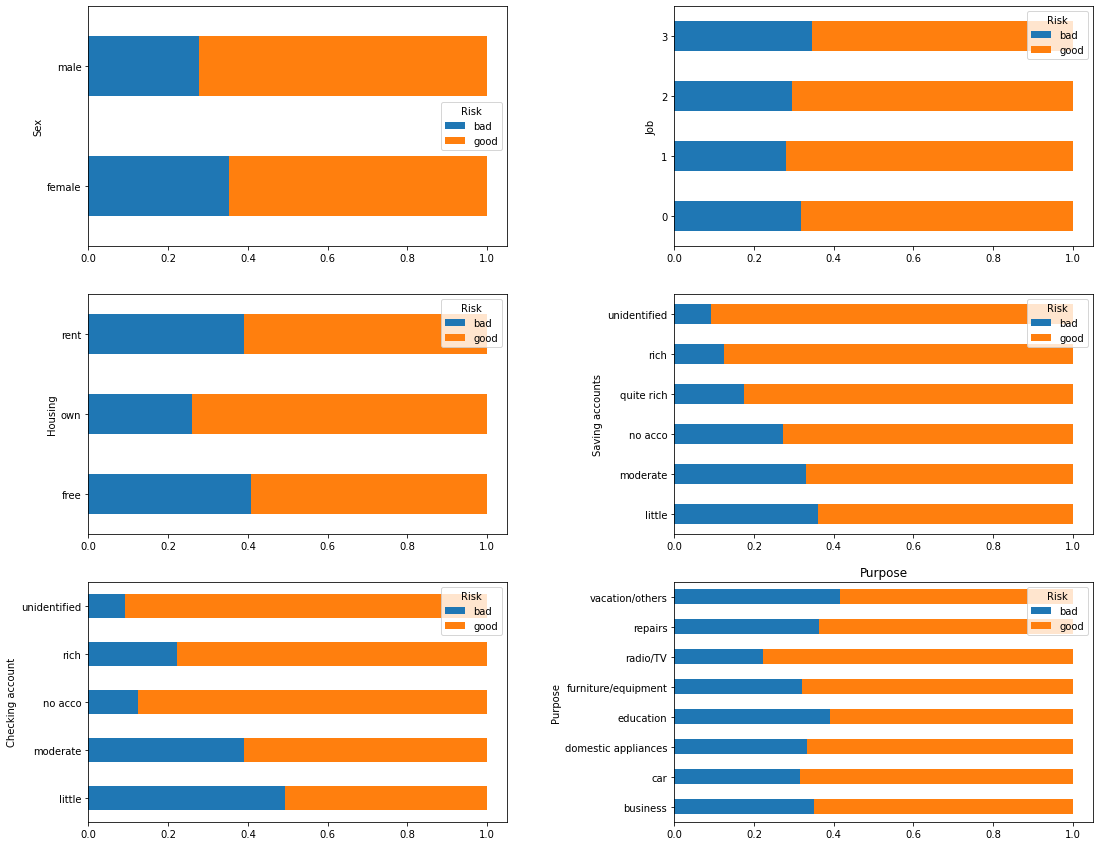

In [36]:
i=0
fig, axes = plt.subplots(3,2, figsize=(18, 15))
for col in category.columns[:-1]:
    dat=category[[col,'Risk']]
    dat_pro=dat.groupby([col,'Risk']).size().reset_index(name='Count')
    #category_proportions = dat_pro.div(dat_pro.sum(axis=1), axis=0)
    
    # this will group the count per category of risk per the column and then use the sum of the risk to get the proprotion
    dat_pro['Proportion'] = dat_pro.groupby(col)['Count'].transform(lambda x: x / x.sum())
    
    # create summary so that the rows are category in column and the column is good and bad
    pivot=dat_pro.pivot(index=col, columns='Risk', values='Proportion').fillna(0)
    pivot.reset_index(inplace=True)
    
    if i%2==0:
        b=int(i/2)
        axa=axes[b,0]
    else:
        b=int((i-1)/2)
        axa=axes[b,1]
    pivot.plot(x=col,stacked=True,kind='barh',ax=axa)
    plt.title(col)

    
    i+=1
plt.subplots_adjust(wspace=0.4)
plt.show()

Here is my summary of findings:
- Sex: Female has higher bad loan compared to it's population. However need to keep in mind that female that has credit in the data are already only around half of the men so this women are quite 'special case'. But since the case, using count it seems that males has higher number on bad loans (but that because most of the loan originated from men).
- Job: Job seems not have any relation to the proportion of bad debt. The proportion of bad debt relatively the same for each category anyway. This could be related to the credit amount or duration but will not be covered on this project. Actually this feature is not that important perhaps if seeing it like this.
- Housing: Those who own it's own housing has lower bad debt than those who rent or get housing 'free'. Perhaps this is because of the already stable finance that those who own the house is compared to those who has rent and 'free' since perhpas they are more likely to get rent hikes or being driven away. Since the most of the loan are given to those who own house then it meant that large proportion of the bad loan come from tho who are rent and free.
- Saving accounts: Actually do indicate that this feature is ordinal feature because there is gradual decrease the more people actually has money in savings accounts (with the exception of no acc and unidentified. Due to it's large count and high proportion, most of the bad debts come from those who has little money on their savings account.
- Checking account: the same as saving accounts
- Purpose: there really seems not a large difference between category on the proportion of bad loans. However there some category that has low bad debt in proportion like tv/radio which is remarkable since actually they are the second one with the most count value. Due to the high count number and high bad debt proportions, car and furniture are the likely source of te quite large number of bad loan followed by education and business. Unusually education had bad loan rate while so is the business which is logical enough.

### 5.b.ii. Chi Square of Independence Test

The chi square test has null hypotesis (H0) that says that the 2 variable in question are independent or not associated while the alternative is the opposite.

In [37]:
# Create a contingency table using pandas crosstab
for col in category.columns[:-1]:
    contingency_table = pd.crosstab(category[col], category['Risk'])

    # Perform the Chi-Square test for independence
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Print the results
    print(col)
    print(f"Chi-Square Value: {chi2}")
    print(f"P-Value: {p}")
    print("---------------------------------------------------")


Sex
Chi-Square Value: 5.348516218081436
P-Value: 0.020739913068713305
---------------------------------------------------
Job
Chi-Square Value: 1.8851560280131707
P-Value: 0.5965815918843431
---------------------------------------------------
Housing
Chi-Square Value: 18.19984158256362
P-Value: 0.00011167465374597684
---------------------------------------------------
Saving accounts
Chi-Square Value: 43.337844623372604
P-Value: 3.1559432669941126e-08
---------------------------------------------------
Checking account
Chi-Square Value: 124.14142641459415
P-Value: 6.96401196026165e-26
---------------------------------------------------
Purpose
Chi-Square Value: 13.642086296939734
P-Value: 0.05792591119293633
---------------------------------------------------


From the test result above, i could conclude that the purpose and Job are independent of Risk. While the rest of the variables are indeed has some association with the Risk feature. Sex is almost not have association with the Risk if i choose the alpha of 1%. Additionally this means that there is difference between probability of good and bad loans in each category for all the variables that has association with the Risk feature. For the follow up of this result is that i will perhaps still use both variables since they perhaps has some correlation with the credit amount or duration. I need to get more insight.

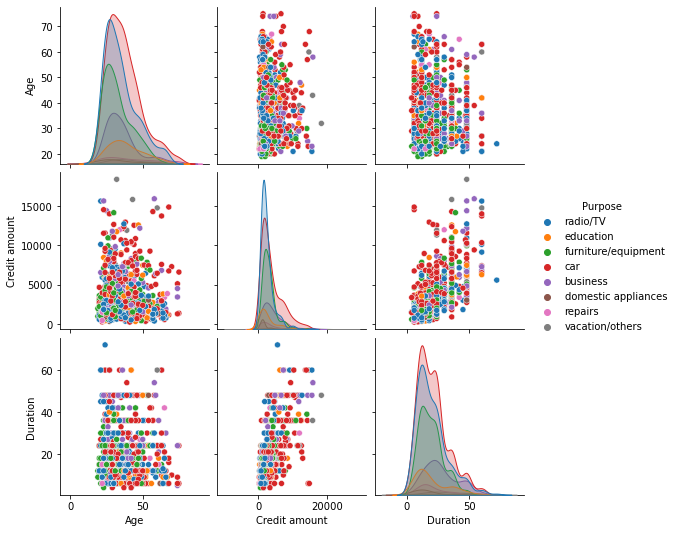

In [38]:
num=['Age','Credit amount','Duration','Purpose']
d=data[num]
sns.pairplot(d,hue='Purpose')

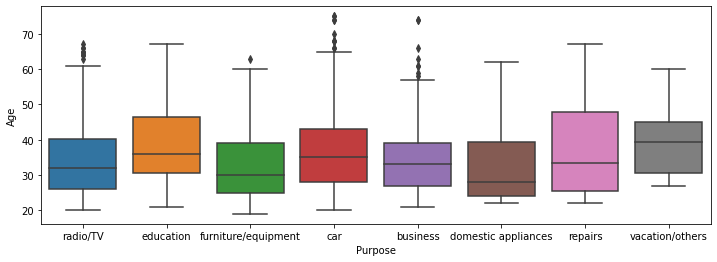

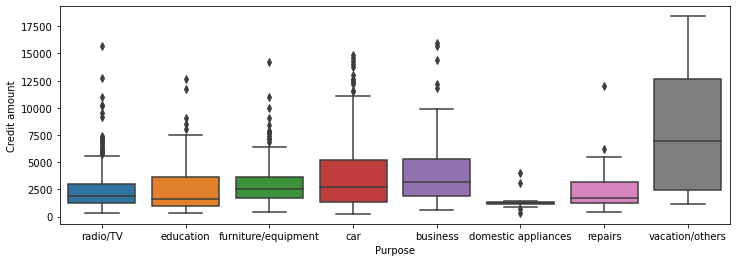

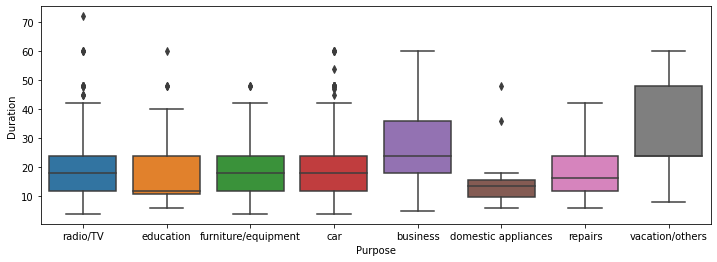

In [39]:
for col in d.columns[:-1]:
    plt.figure(figsize=(12,4))
    sns.boxplot(data=d,y=col,x='Purpose')
    plt.show()

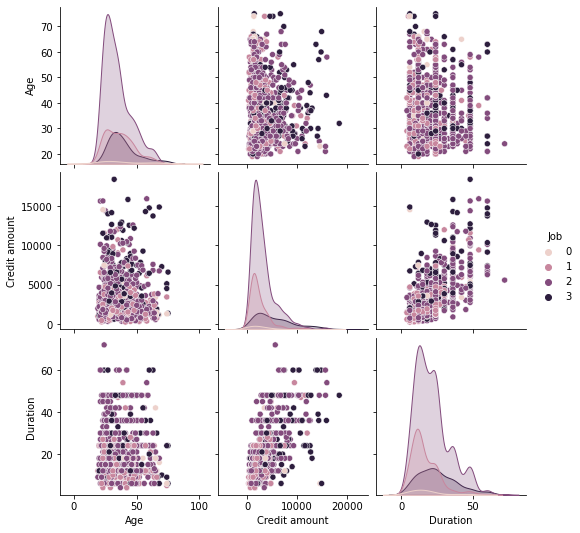

In [40]:
num1=['Age','Credit amount','Duration','Job']
d1=data[num1]
sns.pairplot(d1,hue='Job')

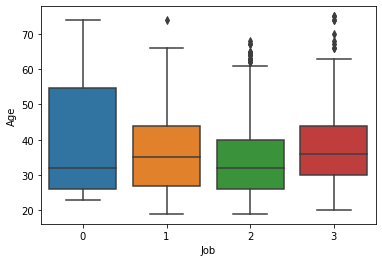

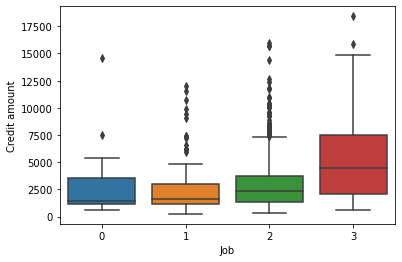

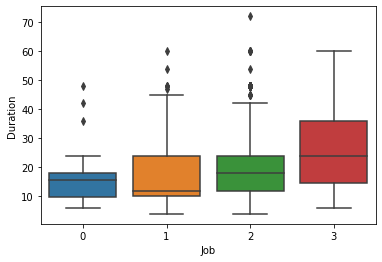

In [41]:
for col in d1.columns[:-1]:
    sns.boxplot(data=d1,y=col,x='Job')
    plt.show()

From further inspection it is founded that Job has some association with with the credit amount and duration. Mean while it is quite unclear relation between purposes and numerical variables except credit amount. For the duration in terms of purpose there is indeed quite the difference in few categories like business and appliances.

## 5.c.Feature Engineering, Selection, and Encoding

From the EDA that already happen, i do already has quite a good grasp on what feature to manipulate and select. 
1. For the first, i will drop rows with 'unidentified' category on saving and checking accounts because it adds confusion on the modelling itself since there both variables are confirmed as ordinal variables.
2. For selection, i will exclude purposes despite it was seen that it is uncorrelated. Here is also the limitation of my model since i will assumed that this model will be used to identify the bad or good loan after the application approved. If the model is to be deployed before the loan is approved then purposes will be included since purpose is necessary to see risk and optimal duration and credit amount.
3. For encoding, i will do ordinal encoding to Saving accounts, Checking account, Job. Additionally the rest of the categorical variables will using one hot encoding while the Risk use binary encoding.

In [42]:
data.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,no acco,little,1169.0,6,radio/TV,good
1,22,female,2,own,little,moderate,5951.0,48,radio/TV,bad
2,49,male,1,own,little,no acco,2096.0,12,education,good
3,45,male,2,free,little,little,7882.0,42,furniture/equipment,good
4,53,male,2,free,little,little,4870.0,24,car,bad
5,35,male,1,free,unidentified,unidentified,9055.0,36,education,good
6,53,male,2,own,quite rich,no acco,2835.0,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948.0,36,car,good
8,61,male,1,own,rich,no acco,3059.0,12,radio/TV,good
9,28,male,3,own,little,moderate,5234.0,30,car,bad


In [43]:
# drop the unidentified
filt=data[data['Saving accounts']=='unidentified']

In [44]:
Data=data.drop(filt.index,axis=0)

In [45]:
Data=Data.drop('Purpose',axis=1)

In [46]:
# do the ordinal encoding
from sklearn.preprocessing import OrdinalEncoder

# create instances of class
ord1=OrdinalEncoder(categories=[['no acco','little','moderate','quite rich','rich']])
ord2=OrdinalEncoder(categories=[['no acco','little','moderate','rich']])

#tranform and fir the encoder
Data['Saving accounts']=ord1.fit_transform(Data[['Saving accounts']])
Data['Checking account']=ord2.fit_transform(Data[['Checking account']])

In [47]:
Data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Risk
0,67,male,2,own,0.0,1.0,1169.0,6,good
1,22,female,2,own,1.0,2.0,5951.0,48,bad
2,49,male,1,own,1.0,0.0,2096.0,12,good
3,45,male,2,free,1.0,1.0,7882.0,42,good
4,53,male,2,free,1.0,1.0,4870.0,24,bad


In [48]:
# do one hot encoding

# gather all the column 
Data1 = pd.get_dummies(Data, columns=['Sex','Housing'])


In [49]:
# do binary mapping to the Risk
Data1.loc[:,'Risk'] = Data1.loc[:,'Risk'].map({'bad': 1, 'good': 0})

In [50]:
mm = MinMaxScaler()

#for numeric feature there will be scaling
numeric=['Age','Credit amount','Duration']
numerical=Data1[numeric]

Data1[numeric] = mm.fit_transform(Data1[numeric])

In [51]:
Data1

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent
0,0.857143,2,0.0,1.0,0.050567,0.029412,0,0,1,0,1,0
1,0.053571,2,1.0,2.0,0.313690,0.647059,1,1,0,0,1,0
2,0.535714,1,1.0,0.0,0.101574,0.117647,0,0,1,0,1,0
3,0.464286,2,1.0,1.0,0.419941,0.558824,0,0,1,1,0,0
4,0.607143,2,1.0,1.0,0.254209,0.294118,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.214286,1,1.0,0.0,0.081765,0.117647,0,1,0,0,1,0
996,0.375000,3,1.0,1.0,0.198470,0.382353,0,0,1,0,1,0
997,0.339286,2,1.0,0.0,0.030483,0.117647,0,0,1,0,1,0
998,0.071429,2,1.0,1.0,0.087763,0.602941,1,0,1,1,0,0


# 6.Train-Test Split & Addressing Unbalanced Class

There is indeed unbalance in the target feature therefore there is the need to address it. Undersampling is out of the question since there will be a lot of information loss. Meanwhile oversampling using SMOTE is quite misleading on this case since the divide in many variables are ambiguous and my of the variables has centered around some value. However if the recall-precision is not satisfactory then the use of SMOTE is necessary.

In [52]:
# create train-test split
X=Data1.drop('Risk',axis=1)
y=Data1['Risk']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [53]:
# unbalanced class
class_weight = {}

# Assign weight of class 0 to be 0.3
class_weight[0] = 0.3

# Assign weight of class 1 to be 0.7
class_weight[1] = 0.7

In [55]:
# smote resampling
#please run it twice
from imblearn.over_sampling import SMOTE
# Create a SMOTE sampler
smote_sampler = SMOTE(random_state = 42)
# Resample training data using SMOTE
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

# 7.Model Creation

In [56]:
# defining function that will help 
def eval_metrix(yt,yp,eval_type='original'):
    result_pos={}
    result_pos['type']=eval_type
    result_pos['accuracy']=accuracy_score(yt, yp)
    
    precision, recall, f_beta, support = precision_recall_fscore_support(yt,yp, beta=5, pos_label=1, average='binary')
    result_pos['precision']=precision
    result_pos['recall']=recall
    result_pos['f1_score']=f_beta
    result_pos['auc'] = roc_auc_score(yt, yp)
    return result_pos

## 7.a.Logistic Regression as Baseline

### Class Reweighting

In [57]:
# Define a logistic regression with weight as baseline model
log_weight = LogisticRegression(max_iter = 1000,
                              class_weight=class_weight)

In [58]:
# Train the model
log_weight.fit(X_train, y_train)
# Make predictions on the test dataset
log_preds = log_weight.predict(X_test)

In [59]:
results=[]

In [60]:
# model evaluation
result=eval_metrix(y_test,log_preds,'Logistic')
results.append(result)
result

{'type': 'Logistic',
 'accuracy': 0.6051660516605166,
 'precision': 0.4394904458598726,
 'recall': 0.7840909090909091,
 'f1_score': 0.7611370386084005,
 'auc': 0.6516082960755092}

### SMOTE

In [61]:
log_smote=LogisticRegression(max_iter = 1000)
# Train the model
log_smote.fit(X_smo, y_smo)
# Make predictions on the test dataset
log_smo = log_smote.predict(X_test)

In [62]:
# model evaluation
result=eval_metrix(y_test,log_smo,'Logistic SMOTE')
results.append(result)
result

{'type': 'Logistic SMOTE',
 'accuracy': 0.6383763837638377,
 'precision': 0.4609375,
 'recall': 0.6704545454545454,
 'f1_score': 0.6589347079037801,
 'auc': 0.6467026825633383}

## 7.b.KNN

### Normal KNN

In [63]:
# searching the best value of k
max_k = 20
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

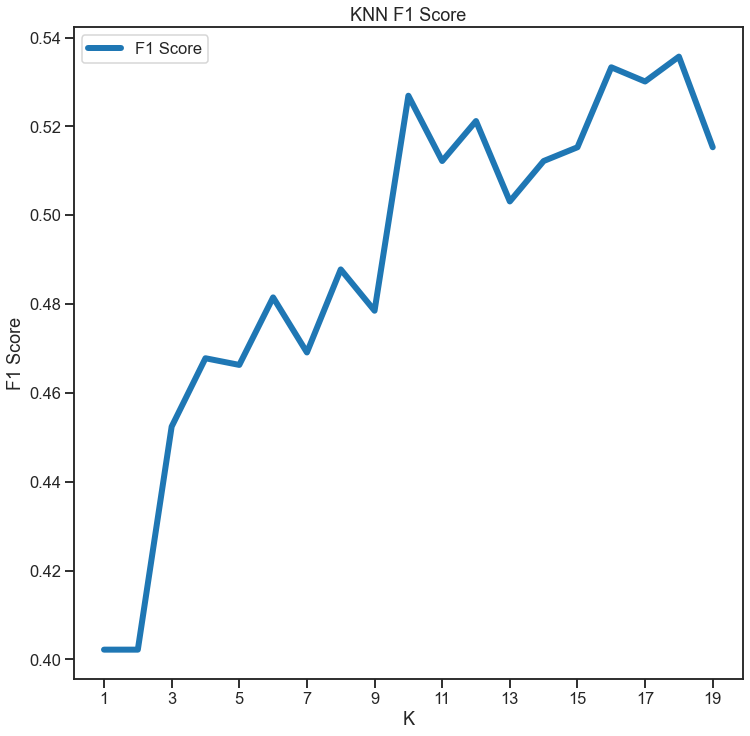

In [64]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

In [65]:
#k_neighbors 11
knn=KNeighborsClassifier(n_neighbors=11)

#fit the model
knn_smo=knn.fit(X_smo,y_smo)

#predict
knn_pred=knn.predict(X_test)

In [66]:
# model evaluation of normal knn -> this can't address inbalanced class
result=eval_metrix(y_test,knn_pred,'KNN No Weight')
results.append(result)
result

{'type': 'KNN No Weight',
 'accuracy': 0.6605166051660517,
 'precision': 0.48484848484848486,
 'recall': 0.7272727272727273,
 'f1_score': 0.7135506003430533,
 'auc': 0.6778440139095878}

### SMOTE

In [67]:
# searching the best value of k
max_k = 20
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_smo, y_smo)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

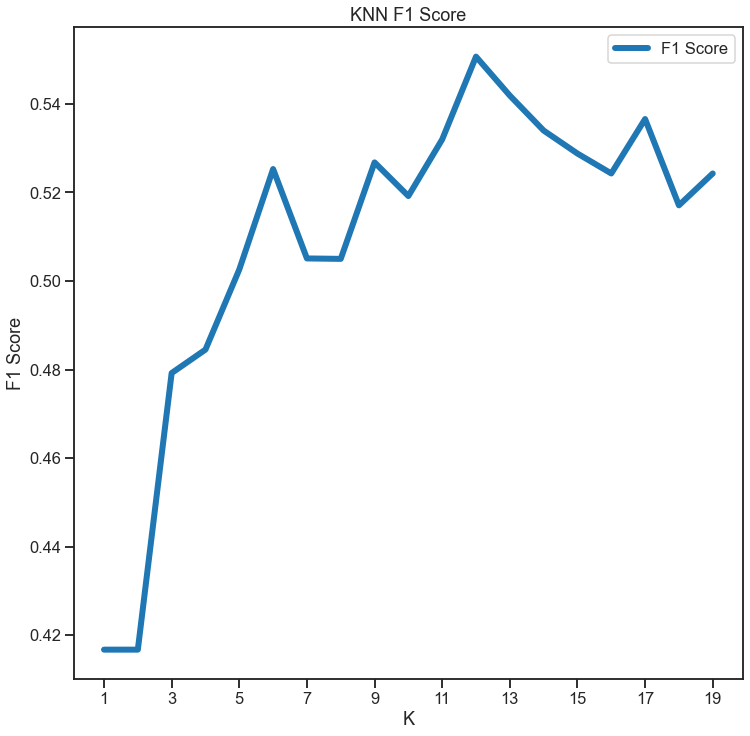

In [68]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

In [69]:
# the best n_neighbor is 12
knn_smo=KNeighborsClassifier(n_neighbors=12)
knn_smo=knn_smo.fit(X_train,y_train)
knn_predmo=knn_smo.predict(X_test)

In [70]:
# model evaluation for smote
result=eval_metrix(y_test,knn_predmo,'KNN SMOTE')
results.append(result)
result

{'type': 'KNN SMOTE',
 'accuracy': 0.7158671586715867,
 'precision': 0.5932203389830508,
 'recall': 0.3977272727272727,
 'f1_score': 0.4028331119964586,
 'auc': 0.633289865871833}

## 5.c.Support Vector Machine

### Class Reweighting

In [71]:
#create instance of class
svm=SVC(class_weight=class_weight)
svmote=SVC()

In [72]:
params_grid = {
    'C': [0.1,1,5,8, 10,15,20,25, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

In [73]:
grid_search = GridSearchCV(estimator = svm, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
# Search the best parameters with training data
grid_search.fit(X_train, y_train.values.ravel())
best_params = grid_search.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [74]:
best_params

{'C': 20, 'kernel': 'rbf'}

In [75]:
# for class reweighting
svm=SVC(class_weight=class_weight,C=20,kernel='rbf')
svm=svm.fit(X_train,y_train)
svm_pred=svm.predict(X_test)

In [76]:
# model evaluation 
result=eval_metrix(y_test,svm_pred,'SVM')
results.append(result)
result

{'type': 'SVM',
 'accuracy': 0.6273062730627307,
 'precision': 0.45112781954887216,
 'recall': 0.6818181818181818,
 'f1_score': 0.6686669524217744,
 'auc': 0.6414555389965226}

### SMOTE

In [77]:
gs = GridSearchCV(estimator = svmote, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
# Search the best parameters with training data
gs.fit(X_smo, y_smo)
best_params = gs.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [78]:
best_params

{'C': 100, 'kernel': 'rbf'}

In [79]:
# for the smote
svmte=SVC(C=100,kernel='rbf')
svmote=svmote.fit(X_smo,y_smo)
svm_mote=svmote.predict(X_test)

In [102]:
# model evaluation 
result=eval_metrix(y_test,svm_mote,'SVM Smote')
results.append(result)
result

{'type': 'SVM Smote',
 'accuracy': 0.6346863468634686,
 'precision': 0.45925925925925926,
 'recall': 0.7045454545454546,
 'f1_score': 0.6903640256959315,
 'auc': 0.6528191753601589}

## 5.d.Decision Tree

In [81]:
dt = DecisionTreeClassifier(random_state=42,class_weight=class_weight)

In [82]:
params_grid = {
    'C': [0.1,1,5,8, 10,15,20,25, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
}
param_grid = {'max_depth':range(1, 6),
              'max_features': range(1, 10)}

GR = GridSearchCV(dt,
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

In [83]:
GR.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight={0: 0.3, 1: 0.7},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'max_features': range(1, 10)},
             scoring='accuracy')

In [84]:
GR.best_params_

{'max_depth': 5, 'max_features': 2}

In [85]:
#create decision tree
DT=DecisionTreeClassifier(random_state=42,class_weight=class_weight,max_depth=5,max_features=2)

#fit the data
DT=DT.fit(X_train,y_train)

#predict
dt_pred=DT.predict(X_test)

In [86]:
# model evaluation 
result=eval_metrix(y_test,dt_pred,'Decision Tree')
results.append(result)
result

{'type': 'Decision Tree',
 'accuracy': 0.5645756457564576,
 'precision': 0.4175824175824176,
 'recall': 0.8636363636363636,
 'f1_score': 0.8295549958018472,
 'auc': 0.642200695479384}

### SMOTE

In [87]:
dt = DecisionTreeClassifier(random_state=42)

In [88]:
params_grid = {
    'C': [0.1,1,5,8, 10,15,20,25, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
}
param_grid = {'max_depth':range(1, 6),
              'max_features': range(1, 10)}

GR = GridSearchCV(dt,
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

In [89]:
GR.fit(X_smo,y_smo)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'max_features': range(1, 10)},
             scoring='accuracy')

In [90]:
GR.best_params_

{'max_depth': 5, 'max_features': 9}

In [91]:
#create decision tree
DTmo=DecisionTreeClassifier(random_state=42,max_depth=5,max_features=9)

#fit the data
DTmo=DTmo.fit(X_smo,y_smo)

#predict
dt_mo=DTmo.predict(X_test)

In [92]:
# model evaluation 
result=eval_metrix(y_test,dt_mo,'Decision Tree SMOTE')
results.append(result)
result

{'type': 'Decision Tree SMOTE',
 'accuracy': 0.6051660516605166,
 'precision': 0.43870967741935485,
 'recall': 0.7727272727272727,
 'f1_score': 0.7507430997876857,
 'auc': 0.6486587183308494}

## 5.e.Random Forest

### Class Reweighting

In [93]:
rf=RandomForestClassifier(class_weight=class_weight)
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}
search = GridSearchCV(estimator=rf, param_grid=param_grid,scoring='f1')
search.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1000 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "D:\Anaconda\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_p

GridSearchCV(estimator=RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='f1')

In [94]:
search.best_params_

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 37}

In [95]:
#create instance
RC=RandomForestClassifier(class_weight=class_weight,n_estimators=27,max_depth=7,max_features='sqrt')

# fit and predict
RC=RC.fit(X_train,y_train)
rf_pred=RC.predict(X_test)

In [96]:
# model evaluation of normal knn -> this can't address inbalanced class
result=eval_metrix(y_test,rf_pred,'Random Forest')
results.append(result)
result

{'type': 'Random Forest',
 'accuracy': 0.6715867158671587,
 'precision': 0.4957983193277311,
 'recall': 0.6704545454545454,
 'f1_score': 0.6614920224234584,
 'auc': 0.6712928464977647}

### SMOTE

In [97]:
rf=RandomForestClassifier()
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}
search = GridSearchCV(estimator=rf, param_grid=param_grid,scoring='f1')
search.fit(X_smo, y_smo)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1000 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1000 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "D:\Anaconda\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "D:\Anaconda\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_p

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='f1')

In [98]:
search.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 33}

In [99]:
#create instance
RCmo=RandomForestClassifier(class_weight=class_weight,n_estimators=35,max_depth=13,max_features='log2')

# fit and predict
RCmo=RCmo.fit(X_smo,y_smo)
rf_mo=RCmo.predict(X_test)

In [100]:
# model evaluation of normal knn -> this can't address inbalanced class
result=eval_metrix(y_test,rf_mo,'Random Forest SMOTE')
results.append(result)
result

{'type': 'Random Forest SMOTE',
 'accuracy': 0.6420664206642066,
 'precision': 0.46017699115044247,
 'recall': 0.5909090909090909,
 'f1_score': 0.5845222654561175,
 'auc': 0.6287878787878789}

# 8.Model Selection

In [103]:
pd.DataFrame(results)

,type,accuracy,precision,recall,f1_score,auc
0,Logistic,0.605166,0.439490,0.784091,0.761137,0.651608
1,Logistic SMOTE,0.638376,0.460938,0.670455,0.658935,0.646703
2,KNN No Weight,0.660517,0.484848,0.727273,0.713551,0.677844
3,KNN SMOTE,0.715867,0.593220,0.397727,0.402833,0.633290
4,SVM,0.627306,0.451128,0.681818,0.668667,0.641456
5,Decision Tree,0.564576,0.417582,0.863636,0.829555,0.642201
6,Decision Tree SMOTE,0.605166,0.438710,0.772727,0.750743,0.648659
7,Random Forest,0.671587,0.495798,0.670455,0.661492,0.671293
8,Random Forest SMOTE,0.642066,0.460177,0.590909,0.584522,0.628788
9,SVM Smote,0.634686,0.459259,0.704545,0.690364,0.652819


From the results above, it could be seen that, if using f1 score and AUC as well as little bias on recall (since this is about fuinding the bad loan so that the bank don't has liquidity problem), i could conclude that KNN has the better performance instead. This could be because of the difficulty in creating the decision boundary on this matter as seen on the EDA.

As per seen in the plot in the EDA, the fact that so large error on the result of this classifier highlight challenge increating decision boundary that able to identify the good and bad loan. The fact that they are closely densely packed with each other itself making the classification difficult. As such perhaps the KNN as the chosen model will be the most appropritae

# 9.Suggestion
There is few suggestion i would make for further development:
- First there is a need to exploration between categorical and numerical data even further
- The need for perhaps other model like boosting would help in prediction
- For the SVM perhaps by maniputaling the c would make it better
- Using another method of addressing model imbalance
- Getting rid of features like job perhpas could help with the prediction